# Find the contours by percentile in 2d PDF

In data analysis we often want to draw contours from a 2d histogram (or 2d PDFs). The standard pyplot contour function returns contours with user specified levels (lines of equal PDF). However when we want the contours corresponding specific percentiles, such as the 1 sigma (2 sigma) contour that contains 68% (95). Such a contour is more meaningful to characterize a 2d distribution.

I'm surprised I could not find a standard library ("an easy way") that does it. Perhaps the package does exist somewhere online. My solutions are below. The strategy is to scan a number of contours until we find the one have the desired percentiles. To calculate the integrated PDF in a contour, we do a quick monte carlo (similar to the calcualtion of pi). 

In [1]:
import numpy as np     
import matplotlib.pyplot as plt
from scipy import interpolate                                                                                                                                                       
from matplotlib.path import Path

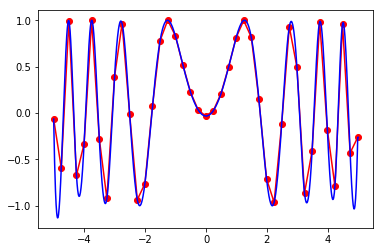

In [4]:
'''
    Example copied online:
    How to use interpolate.interp2d
    This is for my understanding.
'''
x = np.arange(-5.01, 5.01, 0.25)
y = np.arange(-5.01, 5.01, 0.25)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2+yy**2)
f = interpolate.interp2d(x, y, z, kind='cubic')

xnew = np.arange(-5.01, 5.01, 1e-2)
ynew = np.arange(-5.01, 5.01, 1e-2)
znew = f(xnew, ynew)
plt.plot(x, z[0, :], 'ro-', xnew, znew[0, :], 'b-')
plt.show()

In [2]:
'''
   Make binning finer necessary for scanning 
'''
def make_finer_pdf_2d(x, y, prob2d, div=10):
    f_prob2d = interpolate.interp2d(x, y, prob2d)
    x_fine = np.linspace(x[0], x[len(x)-1], len(x)*div)
    y_fine = np.linspace(y[0], y[len(y)-1], len(y)*div)
    prob2d_fine = f_prob2d(x_fine, y_fine)
    return x_fine, y_fine, prob2d_fine

'''
   Randomly sample the pdf
'''
def sample_pdf_2d(x_mesh, y_mesh, prob2d, nsamples):
    prob1d = prob2d.flatten()
    prob1d = prob1d/np.sum(prob1d) # in case not normalized
    index = np.random.choice(len(prob1d), size=nsamples, p=prob1d)
    xvals = x_mesh.flatten()[index]
    yvals = y_mesh.flatten()[index]
    return xvals, yvals

In [35]:
'''
    Make up a simple 2d PDF
    You don't have to make finder PDFs binnings, if
    your PDF is already fine binned
'''
x=np.arange(0.5, 3, 1)
y=np.arange(0.5, 5, 1)
X,Y=np.meshgrid(x,y)
z=np.array([[0,0,0], [0,1,0], [0, 0, 0], [0,0.5,0], [0,0,0]])
xval, yval = sample_pdf_2d(X, Y, z, 100000)

x_fine, y_fine, z_fine = make_finer_pdf_2d(x, y, z, div=100)
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
xval_fine, yval_fine = sample_pdf_2d(X_fine, Y_fine, z_fine, 100000)

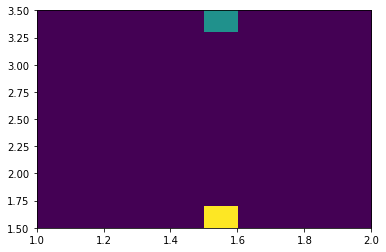

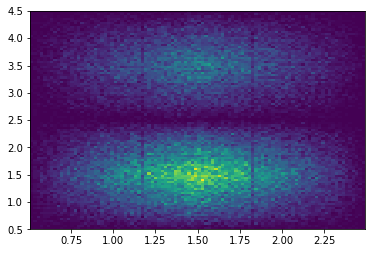

In [36]:
'''
    Show you what the make_finer_pdf_2d and sample_pdf_2d are doing
'''
plt.hist2d(xval, yval)
plt.figure()
plt.hist2d(xval_fine, yval_fine, bins=[100, 100])
plt.show()

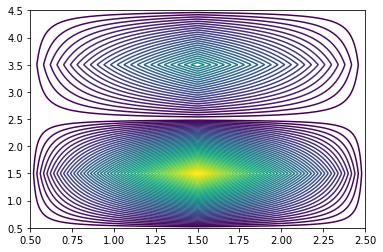

In [37]:
'''
    Plot the fine contours
    The more contours, the better accuracy (also slower).
'''
conts = plt.contour(X_fine, Y_fine, z_fine, 50)

In [38]:
'''
 THE MAIN PERCENTILE SEARCHING FUNCTION
 
    input: 
        conts: the QuadContourSet object returned by pyplot.contour
        xvals: array of randomly sampled points along x-axis 
        yvals: array of randomly sampled points along y-axis 
        target_pct: targeted percentiles. Default to 1,2,3 sigma contours.
        tolerance: the precison of finding. lower tolerance => longer computation time 
    
    output:
        a list. output[n_target_pct][n_graph]
        note: n_graph>1 when there are two peaks in the 2d pdf
        Example: see blocks below
'''

def find_percentile_contour(conts, xvals, yvals, target_pct=[0.68, 0.95, 0.997], tolerance=0.05):

    n_target_pct = len(target_pct)
    if n_target_pct==0:
        print("ERROR: your target percentiles list is empty")
        return ;
    
    n_samples = 0
    if len(xvals)!= len(yvals):
        print("ERROR: your xvals and yvals input have different dimensions!")
        return ;
    else:
        n_samples = len(xvals)

    theSegs = conts.allsegs
    if len(theSegs)<n_target_pct:
        print("ERROR: your available contours is smaller than the number of target contour")
        return ;

    if (n_samples<1e4):
        print("WARNING: your sampled points are too small")
    
    # sort the segments based on incresing levels 
    # prepare the levels from outside -> inside
    # output[0] will be the outter most
    # make target_pct in descenting order
    theLevs = conts.levels
    theSegs = [x for _,x in sorted(zip(theLevs,theSegs))]
    target_pct.sort(reverse=True) 

    points = np.vstack((xvals, yvals)).T
    output=[]
    i0=0;
    for t in range(0, n_target_pct):
        for i in range(i0, len(theSegs)):
            pct=0
            for j in range(len(theSegs[i])):
                aGraph = theSegs[i][j]
                p = Path(aGraph)
                pct += np.sum(p.contains_points(points))/n_samples            
            if (abs(pct-target_pct[t])<=tolerance):
                output.append(theSegs[i])
                i0=i;
                break; # no need to check the rest seg (skip i loop)
    
    if len(output)!= n_target_pct:
        print("WARNING: only ", len(output), " out of ", n_target_pct, " targeted percentiles are found.")
    return output;

In [42]:
'''
    EXAMPLE of how to use the find_percentile_contour function
'''

segs = find_percentile_contour(conts, xval_fine, yval_fine, target_pct=[0.2, 0.95, 0.68])
len(segs)

3

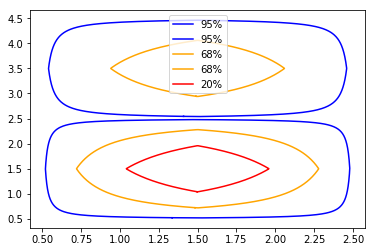

In [46]:
plt.figure()
colors=['blue','orange', 'red']
labels=['95%', '68%', '20%'] #note: the output always outside->inside 
for i in range(0, len(segs)):
    aColor = colors[i]
    aLabel = labels[i]
    for j in range(len(segs[i])):
        aGraph = segs[i][j].T
        if j==0: plt.plot(aGraph[0],aGraph[1], '-', color=aColor, label=aLabel)
        
plt.legend()
plt.show()